<a href="https://colab.research.google.com/github/Um333r/Salifort_Motors/blob/master/Salifort_Motors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

#for data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#for metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.tree import plot_tree

import pickle #saving model

Load Dataset

In [ ]:
file='/content/HR_data.csv'
orginal_df=pd.read_csv(file)

In [ ]:
orginal_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Initial EDA and Data Cleaning

In [ ]:
#Information about the data
orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
#Descriptive statistics about the data
orginal_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
f=orginal_df.columns

In [ ]:
orginal_df.columns=f.str.lower()

In [ ]:
orginal_df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [ ]:
orginal_df.isna().sum() #missing values

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing valuves in any of the columns

In [ ]:
#Duplicates
orginal_df.duplicated().sum()


3008

There are 3008 rows contains duplicates. That is 20% of the data.

In [ ]:
orginal_df[orginal_df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [ ]:
df_cleaned=orginal_df.drop_duplicates(keep='first')


**Check Outliers**

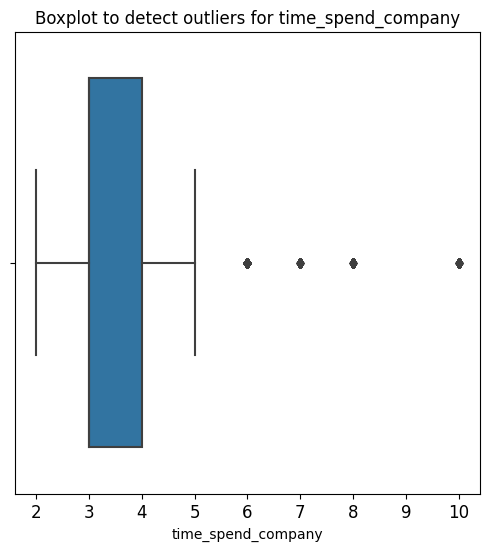

In [ ]:
#BoxPlot for visualize distribution of 'time_spend_company' and to detect outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for time_spend_company', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df_cleaned['time_spend_company'])
plt.show()

The boxplot above shows that there are outliers in the tenure variable.

It would be helpful to investigate how many rows in the data contain outliers in the column.

In [ ]:
#to determine the number of rows containing outliers

#compute the 25th and 75th percentile value in 'time_spend_company'
percentile25= df_cleaned['time_spend_company'].quantile(0.25)
percentile75=df_cleaned['time_spend_company'].quantile(0.75)
#interquartile range in 'time_spend_company'
iqr= percentile75-percentile25
iqr


1.0

In [ ]:
# the upper limit and lower limit for non-outliner values in time_spend_company
upper_limit = percentile75+1.5*iqr
lower_limit = percentile25-1.5*iqr
print('lower Limit:', lower_limit)
print('upper_limit:',upper_limit)

#Identify subset of the data containing outliers in time_spend_company
outliers= df_cleaned[(df_cleaned['time_spend_company']>upper_limit) | (df_cleaned['time_spend_company']<lower_limit)]

# rows in the data containig outliers in 'time_spend_company' column
print("number of rows in the data containing outliers in 'time_spend_company':", len(outliers))

lower Limit: 1.5
upper_limit: 5.5
number of rows in the data containing outliers in 'time_spend_company': 824


In [ ]:
# Number of people who left vs stayed
print(df_cleaned['left'].value_counts())
print()
# Percentages of people who left vs stayed
print(df_cleaned['left'].value_counts(normalize=True))

0    10000
1     1991
Name: left, dtype: int64

0    0.833959
1    0.166041
Name: left, dtype: float64


In [ ]:
df_cleaned['average_montly_hours'].dtype

dtype('int64')

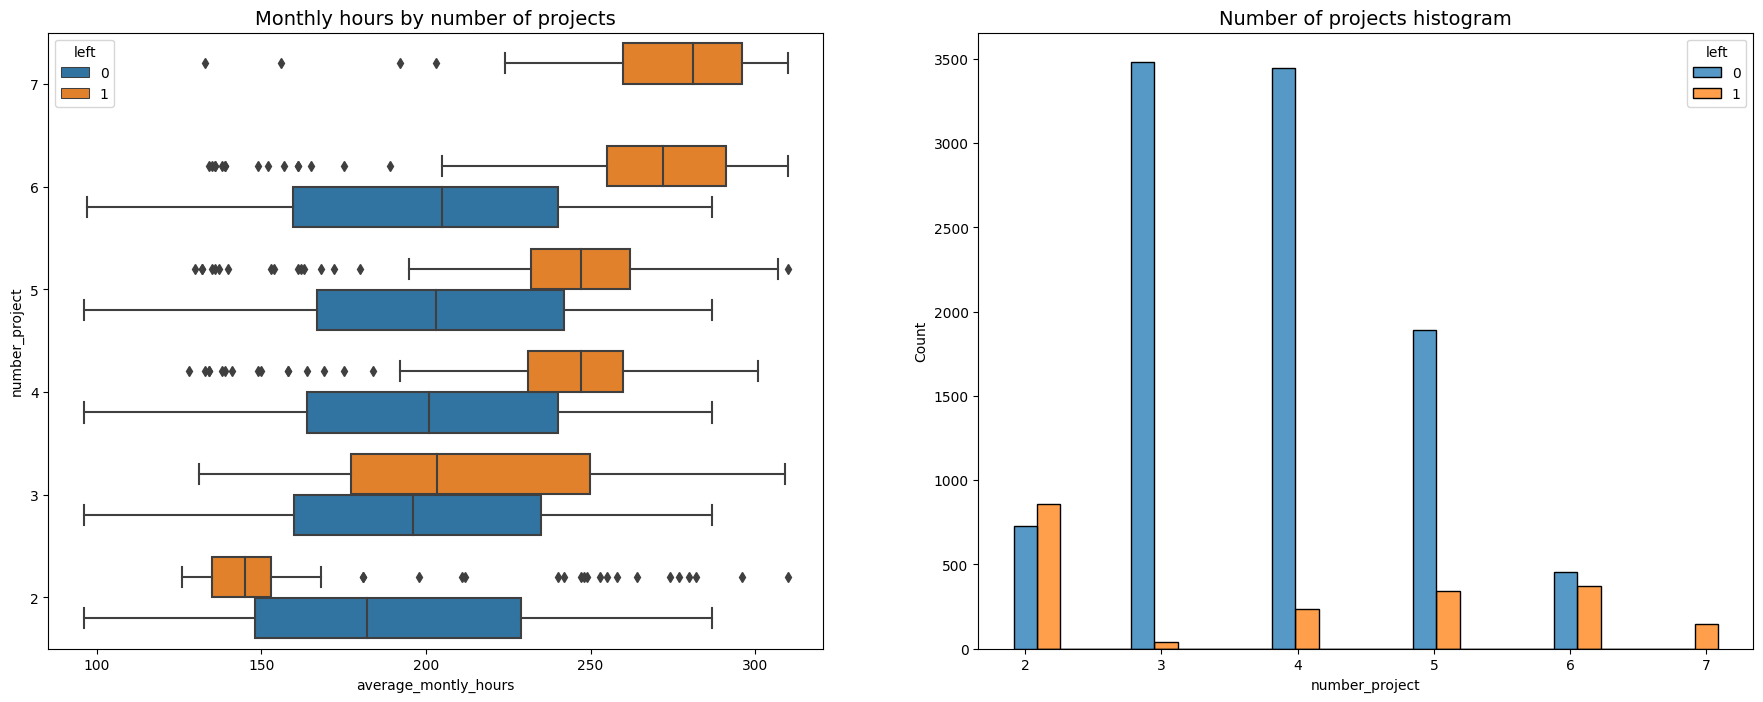

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df_cleaned,x='average_montly_hours',y='number_project',hue='left',orient="h",ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

sns.histplot(data=df_cleaned, x='number_project', hue='left', multiple='dodge',shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
plt.show()



It might be natural that people who work on more projects would also work longer hours. This
appears to be the case here, with the mean hours of each group (stayed and left) increasing with
number of projects worked. However, a few things stand out from this plot.
1. There are two groups of employees who left the company: (A) those who worked considerably
less than their peers with the same number of projects, and (B) those who worked much
more. Of those in group A, it’s possible that they were fired. It’s also possible that this group
includes employees who had already given their notice and were assigned fewer hours because
they were already on their way out the door. For those in group B, it’s reasonable to infer
that they probably quit. The folks in group B likely contributed a lot to the projects they
worked in; they might have been the largest contributors to their projects.
2. Everyone with seven projects left the company, and the interquartile ranges of this group and
those who left with six projects was ~255–295 hours/week—much more than any other group.
3. The optimal number of projects for employees to work on seems to be 3–4. The ratio of
left/stayed is very small for these cohorts.
4. If you assume a work week of 40 hours and two weeks of vacation per year, then the average
number of working hours per month of employees working Monday–Friday = 50 weeks * 40
hours per week / 12 months = 166.67 hours per month. This means that, aside from
the employees who worked on two projects, every group—even those who didn’t leave the
company—worked considerably more hours than this. It seems that employees here are
overworked

In [ ]:
df_cleaned[df_cleaned['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

This Confirms that all employees with 7 project did leave.

Examine the average monthly hours versus the satisfaction levels.


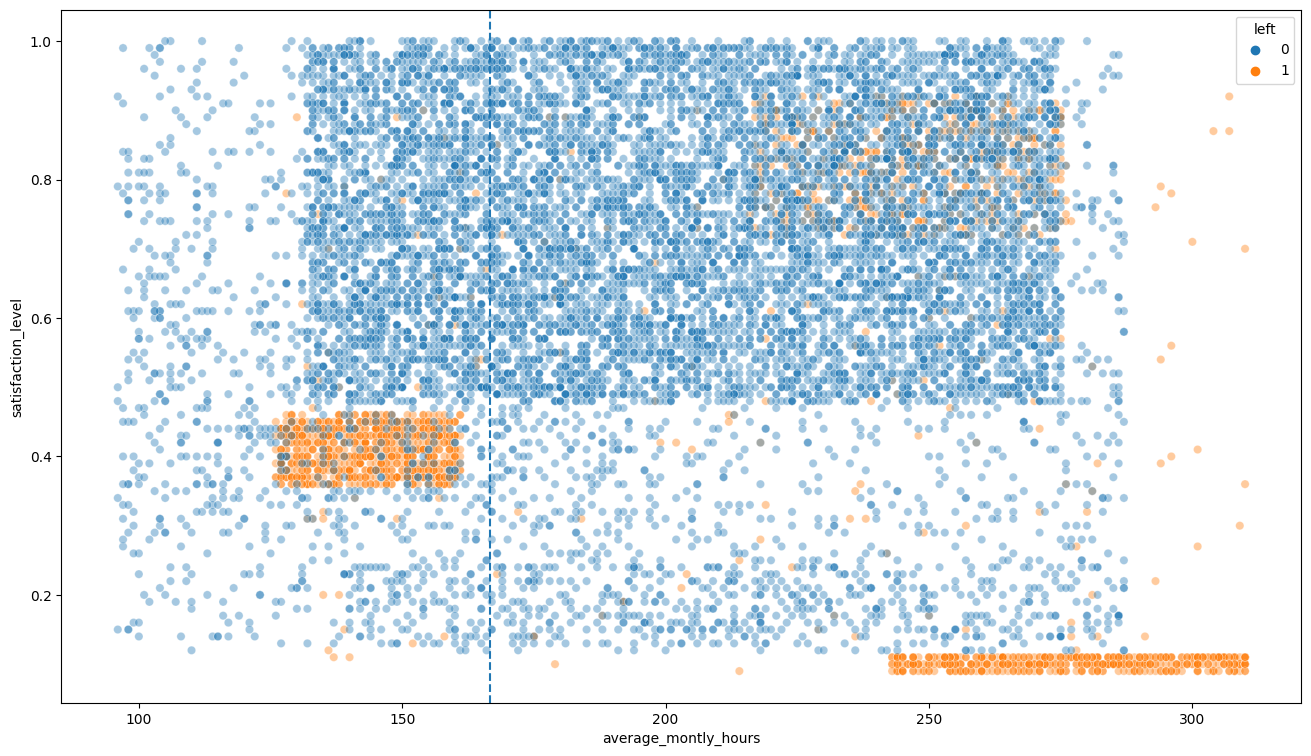

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_cleaned,x='average_montly_hours',y='satisfaction_level',hue='left',alpha=0.4)
plt.axvline(x=166.67,label='166.67 hrs/mo',ls='--')

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315
hours per month. 315 hours per month is over 75 hours per week for a whole year. It’s likely this
is related to their satisfaction levels being close to zero.


The plot also shows another group of people who left, those who had more normal working hours.
Even so, their satisfaction was only around 0.4. It’s difficult to speculate about why they might
have left. It’s possible they felt pressured to work more, considering so many of their peers worked
more. And that pressure could have lowered their satisfaction levels.


Finally, there is a group who worked ~210–280 hours per month, and they had satisfaction levels
ranging ~0.7–0.9.

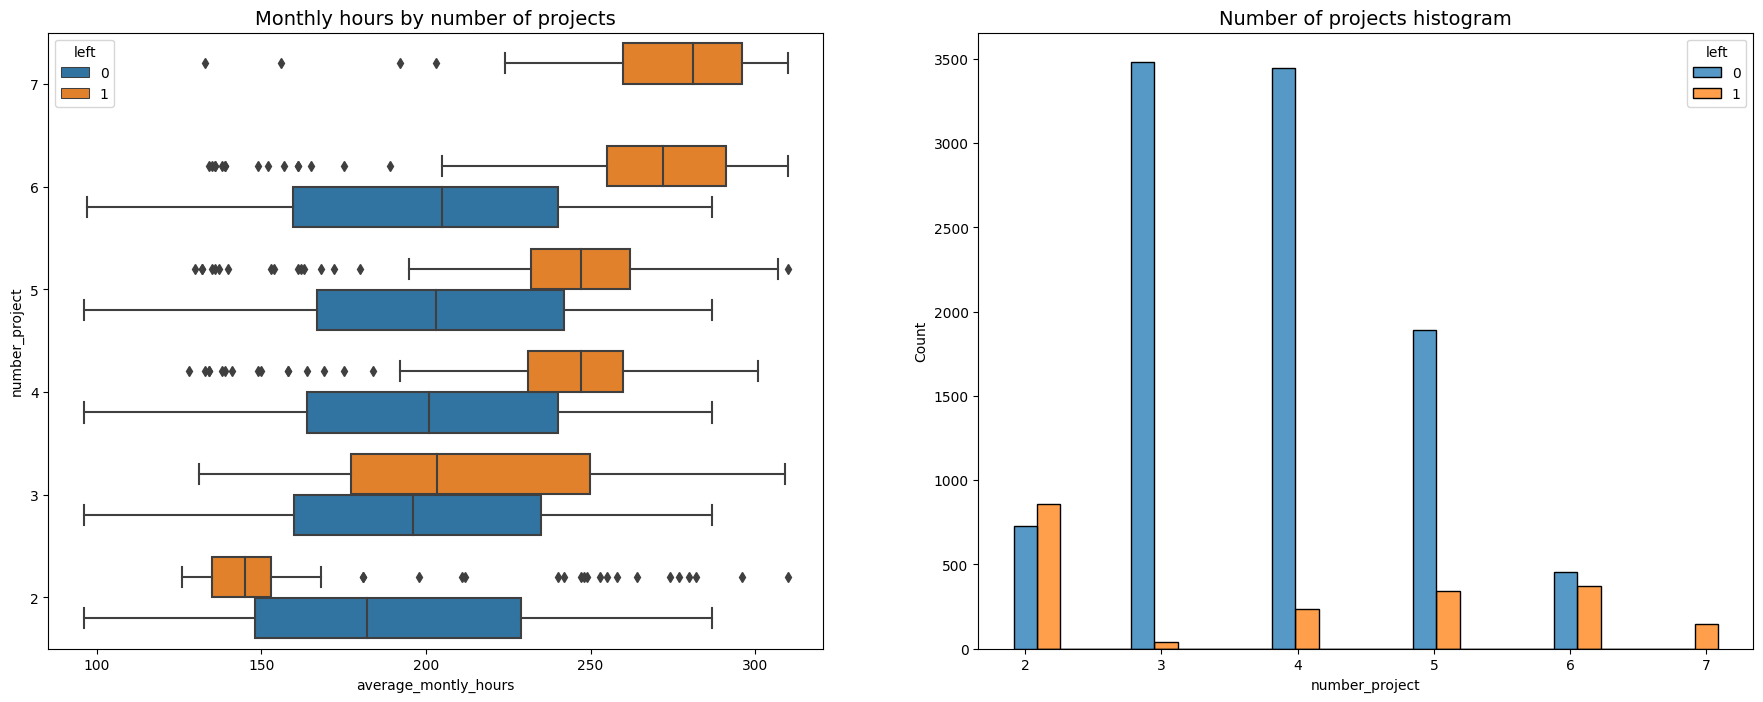

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create boxplot showing `average_monthly_hours` distributions for␣`number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df_cleaned, x='average_montly_hours', y='number_project',hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')
# histogram showing distribution of `number_project`, comparing␣ employees who stayed versus those who left
tenure_stay = df_cleaned[df_cleaned['left']==0]['number_project']
tenure_left = df_cleaned[df_cleaned['left']==1]['number_project']
sns.histplot(data=df_cleaned, x='number_project', hue='left', multiple='dodge',shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
# Display the plots
plt.show()

There are many observations you could make from this plot. - Employees who left fall into two
general categories: dissatisfied employees with shorter tenures and very satisfied employees with
medium-length tenures. - Four-year employees who left seem to have an unusually low satisfaction
level. It’s worth investigating changes to company policy that might have affected people specifically
at the four-year mark, if possible. - The longest-tenured employees didn’t leave. Their satisfaction
levels aligned with those of newer employees who stayed. - The histogram shows that there are
relatively few longer-tenured employees. It’s possible that they’re the higher-ranking, higher-paid
employees.

In [ ]:
df_cleaned.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


As expected, the mean and median satisfaction scores of employees who left are lower than those
of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score
appears to be slightly below the median score. This indicates that satisfaction levels among those
who stayed might be skewed to the left.

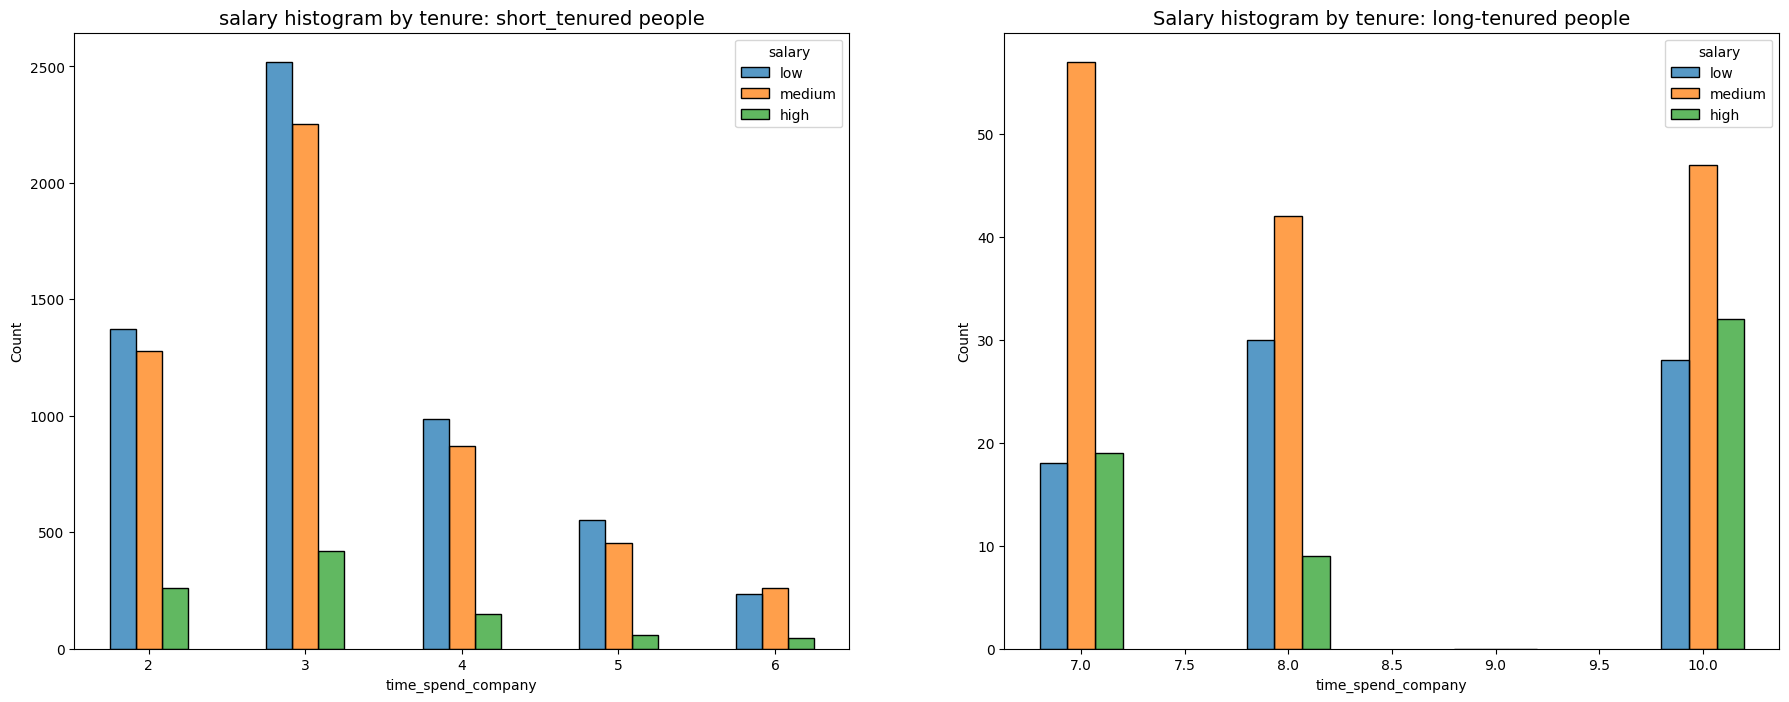

In [ ]:
# Salary level for different tenures.
fig,ax=plt.subplots(1,2,figsize=(22,8))
tenure_short=df_cleaned[df_cleaned['time_spend_company']<7]
tenure_long=df_cleaned[df_cleaned['time_spend_company']>6]

sns.histplot(data=tenure_short,x='time_spend_company', hue='salary',discrete=1,hue_order=['low','medium','high'],multiple='dodge',shrink=0.5,ax=ax[0])
ax[0].set_title('salary histogram by tenure: short_tenured people',fontsize='14')

# plot long_tenured histogram
sns.histplot(data=tenure_long, x='time_spend_company',hue='salary', discrete=1,hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4,ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people',fontsize='14');

The plots above show that long-tenured employees were not disproportionately comprised of higher paid employees.

Text(0.5, 1.0, 'Monthly hours by promotion last 5 Years')

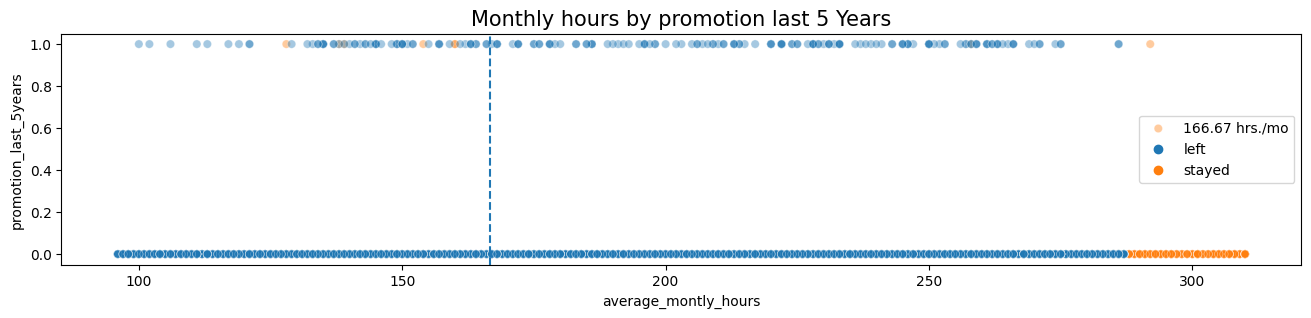

In [ ]:
, label_ranking_loss
#create plot to examine relationship between Average Monthly Hours and promotion last 5 years
plt.figure(figsize=(16,3))
sns.scatterplot(data=df_cleaned,x='average_montly_hours',y='promotion_last_5years',hue='left',alpha=0.4)
plt.axvline(x=166.67,ls='--')
plt.legend(labels= ['166.67 hrs./mo','left','stayed'])
plt.legend(labels=['166.67 hrs./mo','left','stayed'])
plt.title('Monthly hours by promotion last 5 Years', fontsize='15')

The plot above shows the following: - very few employees who were promoted in the last five years
left - very few employees who worked the most hours were promoted - all of the employees who left
were working the longest hours

In [ ]:
df_cleaned['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

Text(0.5, 1.0, 'Counts of stayed/lest by department')

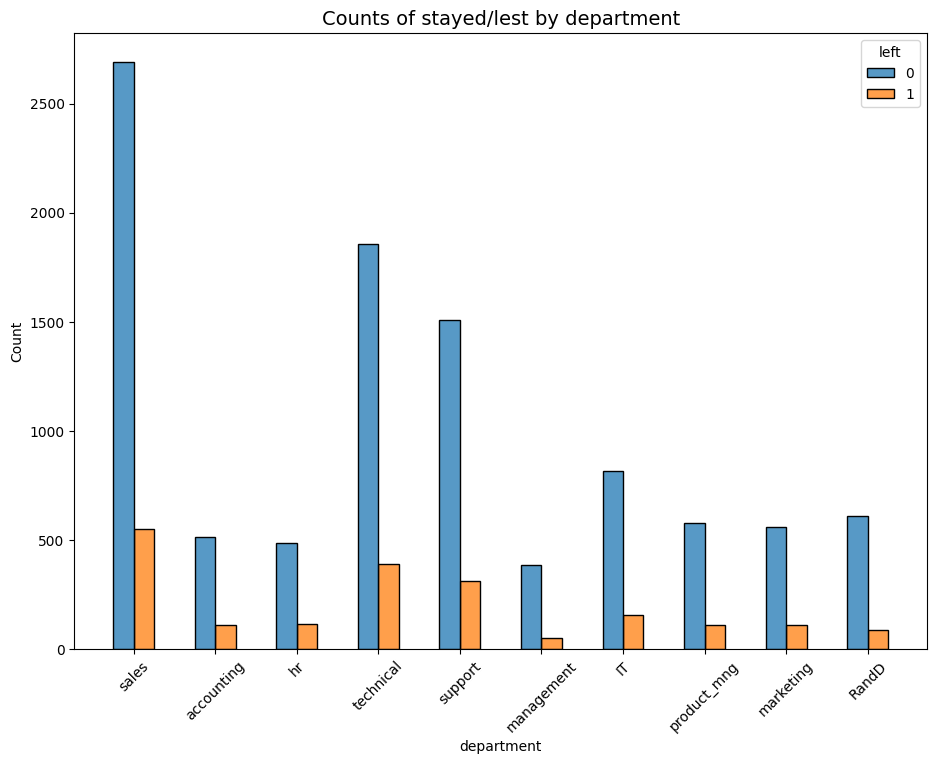

In [ ]:
#Histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df_cleaned,x='department',hue='left',discrete=1,hue_order=[0,1],multiple='dodge',shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/lest by department',fontsize=14)

The plot above shows the following: - very few employees who were promoted in the last five years
left - very few employees who worked the most hours were promoted - all of the employees who left
were working the longest hour

<ipython-input-27-320330c4f6a0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap=sns.heatmap(df_cleaned.corr(), vmin=-1,vmax=1,annot=True,cmap=sns.color_palette("vlag", as_cmap=True))


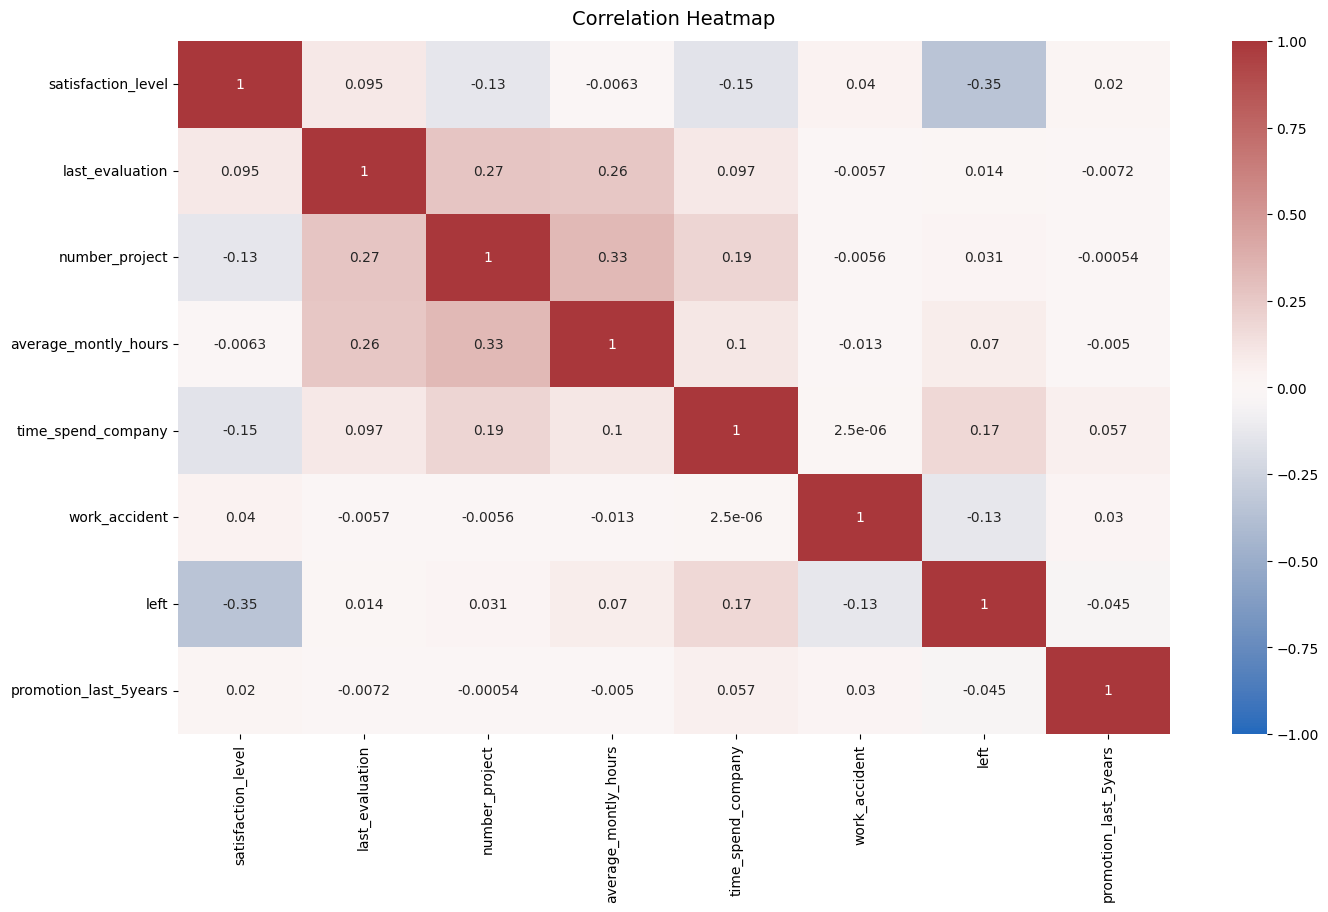

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(16,9))
heatmap=sns.heatmap(df_cleaned.corr(), vmin=-1,vmax=1,annot=True,cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);


The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores
all have some positive correlation with each other, and whether an employee leaves is negatively
correlated with their satisfaction level.

It appears that employees are leaving the company as a result of poor management. Leaving is
tied to longer working hours, many projects, and generally lower satisfaction levels. It can be
ungratifying to work long hours and not receive promotions or good evaluation scores. There’s a
sizeable group of employees at this company who are probably burned out. It also appears that if
an employee has spent more than six years at the company, they tend not to leave.

 Model 1: Logistic Regression Model

In [ ]:
df_enc= df_cleaned.copy()

#Encode the 'salary' column as an ordinal numeric category

df_enc['salary'] = ( df_enc['salary'].astype('category').cat.set_categories(['low','medium','high']).cat.codes)

# encode the department column
df_enc= pd.get_dummies(df_enc,drop_first=False)
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


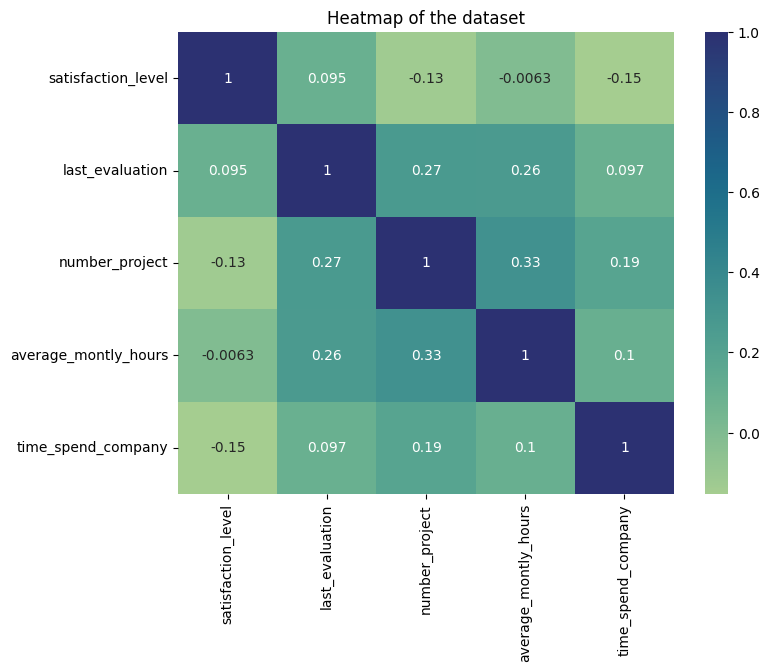

In [ ]:
#Heatmap to visualiz how correlatedd variables are

plt.figure(figsize=(8,6))
sns.heatmap(df_enc[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']].corr(),annot=True,cmap='crest')
plt.title('Heatmap of the dataset')
plt.show()

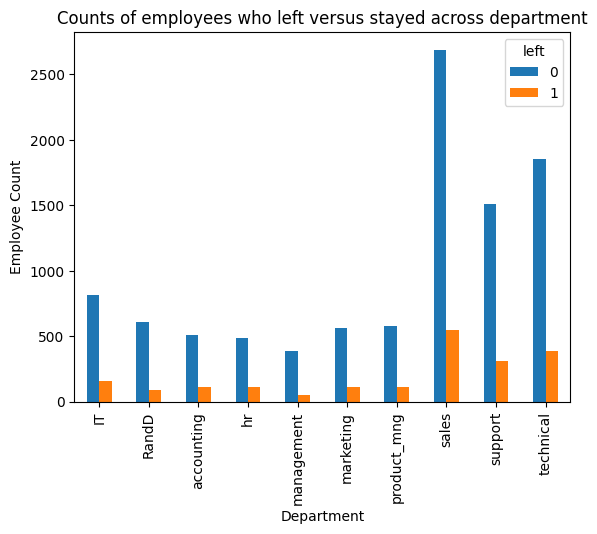

In [ ]:
# Bar plot to visualize number of employees across department, comparing those who left with those who didn't
pd.crosstab(df_cleaned['department'],df_cleaned['left']).plot(kind='bar')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee Count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove
the outliers in the 'time_spend_company' column.

In [ ]:
#dropping rows with outliers in time_spend_company
df_logreg= df_enc[(df_enc['time_spend_company']>=lower_limit ) & (df_enc['time_spend_company']<=upper_limit)]

In [ ]:
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# spliting data into x and y
y=df_logreg['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [ ]:
X=df_logreg.drop('left',axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Spliting data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)

In [ ]:
# Construct a logistic regression model and fit it to the training dataset
log_clf=LogisticRegression (random_state=42,max_iter=500).fit(X_train,y_train)

In [ ]:
# logistic regression model to get predictions on the test set
y_pred=log_clf.predict(X_test)

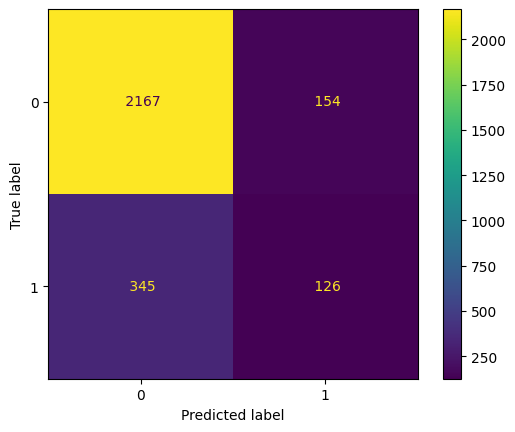

In [ ]:
# Values Confusion_matrix
log_cm=confusion_matrix(y_test,y_pred,labels=log_clf.classes_)

log_disp= ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)
log_disp.plot(values_format=' ')
plt.show()

In [ ]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too
imbalanced. If it was more severely imbalanced, you might want to resample the data to make
it more balanced. In this case, you can use this data without modifying the class balance and
continue evaluating the model.


In [ ]:
#Classification report for logistic regression model
target_names=['Predicted would not leave','Predicted would leave']
print(classification_report(y_test,y_pred,target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.45      0.27      0.34       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.60      0.62      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 79%,
recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. However, if it’s most
important to predict employees who leave, then the scores are significantly lower.


Model:02 **Tree Based Model**

In [ ]:
y=df_enc['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [ ]:
x=df_enc.drop('left', axis=1)
x.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42,stratify=y)

In [ ]:
#instantiate model
tree = DecisionTreeClassifier(random_state=0)

In [ ]:
cv_params={'max_depth': [4,6,8,None],
           'min_samples_leaf':[2,5,1],
           'min_samples_split':[2,4,6]}
scoring={'accuracy','precision','recall','f1','roc_auc'}

tree1=GridSearchCV(tree,cv_params,scoring=scoring,cv=4,refit='roc_auc')

In [ ]:
%%time
tree1.fit(x_train,y_train)

CPU times: user 5.49 s, sys: 25.9 ms, total: 5.51 s
Wall time: 7.5 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'roc_auc', 'accuracy', 'precision', 'f1'})

In [ ]:
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
#best auc score on cv
tree1.best_score_

0.9758877392438816

This is a strong AUC score, which shows that his model can predict employees who will leave very well.


In [ ]:
def make_results (model_name:str,model_object,metric:str):
    metric_dict={'auc': 'mean_test_roc_auc',
               'precision':'mean_test_precision',
               'f1':'mean_test_f1',
               'recall':'mean_test_recall',
               'accuracy':'mean_test_accuracy'}
    cv_results=pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]
    auc= best_estimator_results.mean_test_roc_auc
    f1= best_estimator_results.mean_test_f1
    recall= best_estimator_results.mean_test_recall
    precision=best_estimator_results.mean_test_precision
    accuracy= best_estimator_results.mean_test_accuracy

    table=pd.DataFrame({'model':[model_name],
                      'precision':[precision],
                      'recall':[recall],
                      'F1':[f1],
                      'Accuracy':[accuracy],
                      'auc':[auc]})
    return table


In [ ]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results


,model,precision,recall,F1,Accuracy,auc
0,decision tree cv,0.966878,0.918288,0.941941,0.981208,0.975888


All of these scores from the decision tree model are strong indicators of good model performance.

Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by
incorporating multiple trees to make predictions.



Random forest

In [ ]:
rf = RandomForestClassifier(random_state=0)
# Hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
'max_features': [1.0],
'max_samples': [0.7, 1.0],
'min_samples_leaf': [1,2,3],
'min_samples_split': [2,3,4],
'n_estimators': [300, 500],
}
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf1.fit(x_train,y_train)

CPU times: user 28min 48s, sys: 3.9 s, total: 28min 52s
Wall time: 29min 14s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'roc_auc', 'accuracy', 'precision', 'f1'})

In [ ]:
path =" r C:Users\mohum\OneDrive\Desktop\newfar"


In [ ]:
def write_pickle(path,model_object,save_as:str):
  with open(path + save_as + '.pickle','wb') as to_write:
    pickle.dump(model_object,to_write)

In [ ]:
def read_pickle(path,saved_model_name: str):
  with open( path + saved_model_name + '.pickle','rb') as to_read:
    model = pickle.load(to_read)

    return model

In [ ]:
# Write pickle
write_pickle(path,rf1,'hr_rf1')

In [ ]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')


In [ ]:
 # Check best AUC score on CV
rf1.best_score_

0.9822377413943887

In [ ]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
#Get all CV score
rf1_cv_results= make_results('random forest cv',rf1,'auc')
print(tree1_cv_results)
print(rf1_cv_results)


              model  precision    recall        F1  Accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888
              model  precision    recall       F1  Accuracy       auc
0  random forest cv   0.946269  0.919628  0.93273  0.977983  0.982238


The evaluation scores of the random forest model are better than those of the decision tree model,
with the exception of recall (the recall score of the random forest model is approximately 0.001 lower,
which is a negligible amount). This indicates that the random forest model mostly outperforms
the decision tree model.


In [ ]:
def get_scores(model_name:str, model,x_test_data,y_test_data):
  preds=model.best_estimator_.predict(x_test_data)
  auc= roc_auc_score(y_test_data,preds)
  accuracy=accuracy_score(y_test_data,preds)
  precision=precision_score(y_test_data,preds)
  recall=recall_score(y_test_data,preds)
  f1=f1_score(y_test_data,preds)

  table=pd.DataFrame({'model':[model_name],
                      'precision':[precision],
                      'recall':[recall],
                      'f1':[f1],
                      'accuracy':[accuracy],
                      'AUC':[auc]})
  return table

In [ ]:
rf1_test_scores=get_scores('random forest test', rf1,x_test,y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest test,0.954262,0.921687,0.937692,0.979653,0.956443


In The first round of decision tree and random forest models we have included all variables as features. In This
next round will incorporate feature engineering to build improved models.

Dropping satisfaction_level and creating a new feature that roughly
captures whether an employee is overworked. You could call this new feature overworked. It will
be a binary variable

In [ ]:
#Drop 'Satisfaction level' column
df2= df_enc.drop('satisfaction_level', axis=1)

df2.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Renaming 'average_monthly_hours' column as 'overworked'
df2['overworked']=df2['average_montly_hours']
print('Max Hours', df2['overworked'].max())
print('Min Hours',df2['overworked'].min())

Max Hours 310
Min Hours 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per
year, 5 days per week, 8 hours per day.


we can consider 175 hours per month on average as overworked.



In [ ]:
df2['overworked']=(df2['overworked']>175).astype(int)
df2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [ ]:
df2.drop('average_montly_hours',axis=1,inplace=True)

In [ ]:
df2.head()

,last_evaluation,number_project,time_spend_company,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
y=df2['left']
x= df2.drop('left',axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,stratify=y, random_state=0)


**Decision Tree - 02**

In [ ]:
tree= DecisionTreeClassifier(random_state=0)
cv_params={'max_depth':[4,6,8,None],
           'min_samples_leaf':[2,5,1],
           'min_samples_split':[2,4,6]}
scoring={'accuracy','precision','recall','f1','roc_auc'}
tree2=GridSearchCV(tree,cv_params,scoring=scoring,cv=4,refit='roc_auc')

In [ ]:
%%time
tree2.fit(x_train,y_train)

CPU times: user 3.91 s, sys: 3.01 ms, total: 3.92 s
Wall time: 3.94 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'roc_auc', 'accuracy', 'precision', 'f1'})

In [ ]:
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [ ]:
tree2.best_score_

0.9586752505340426

In [ ]:
 # Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)


              model  precision    recall        F1  Accuracy       auc
0  decision tree cv   0.966878  0.918288  0.941941  0.981208  0.975888
               model  precision    recall        F1  Accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675


Random Forest-02

In [ ]:
rf= RandomForestClassifier(random_state=0)

cv_params={'max_depth':[3,5,None],
           'max_features':[1.0],
           'max_samples':[0.7,1.0],
           'min_samples_leaf':[1,2,3],
           'min_samples_split':[2,3,4],
           'n_estimators':[300,500]}
scoring={'accuracy','precision','recall','f1','roc_auc'}

rf2=GridSearchCV(rf,cv_params,scoring=scoring,cv=4,refit='roc_auc')

In [ ]:
%%time
rf2.fit(x_train,y_train)

CPU times: user 20min 31s, sys: 1.96 s, total: 20min 33s
Wall time: 20min 48s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'roc_auc', 'accuracy', 'precision', 'f1'})

In [ ]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')


In [ ]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [ ]:
rf2.best_params_


{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
rf2.best_score_


0.9648100662833985

In [ ]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  Accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
               model  precision    recall        F1  Accuracy      auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.96481


In [ ]:
rf2_test_scores = get_scores('random forest2 test', rf2, x_test, y_test)
rf2_test_scores


,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.870406,0.903614,0.8867,0.961641,0.938407


This seems to be a stable model


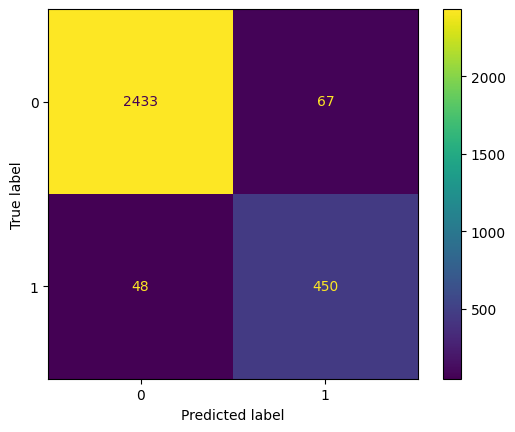

In [ ]:
#Confusion Matrix
preds= rf2.best_estimator_.predict(x_test)
cm= confusion_matrix(y_test,preds,labels=rf2.classes_)

disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf2.classes_)
disp.plot(values_format='');


The model predicts more false positives than false negatives, which means that some employees
may be identified as at risk of quitting or getting fired, when that’s actually not the case. But this
is still a strong model.

**Decision Tree Splits**

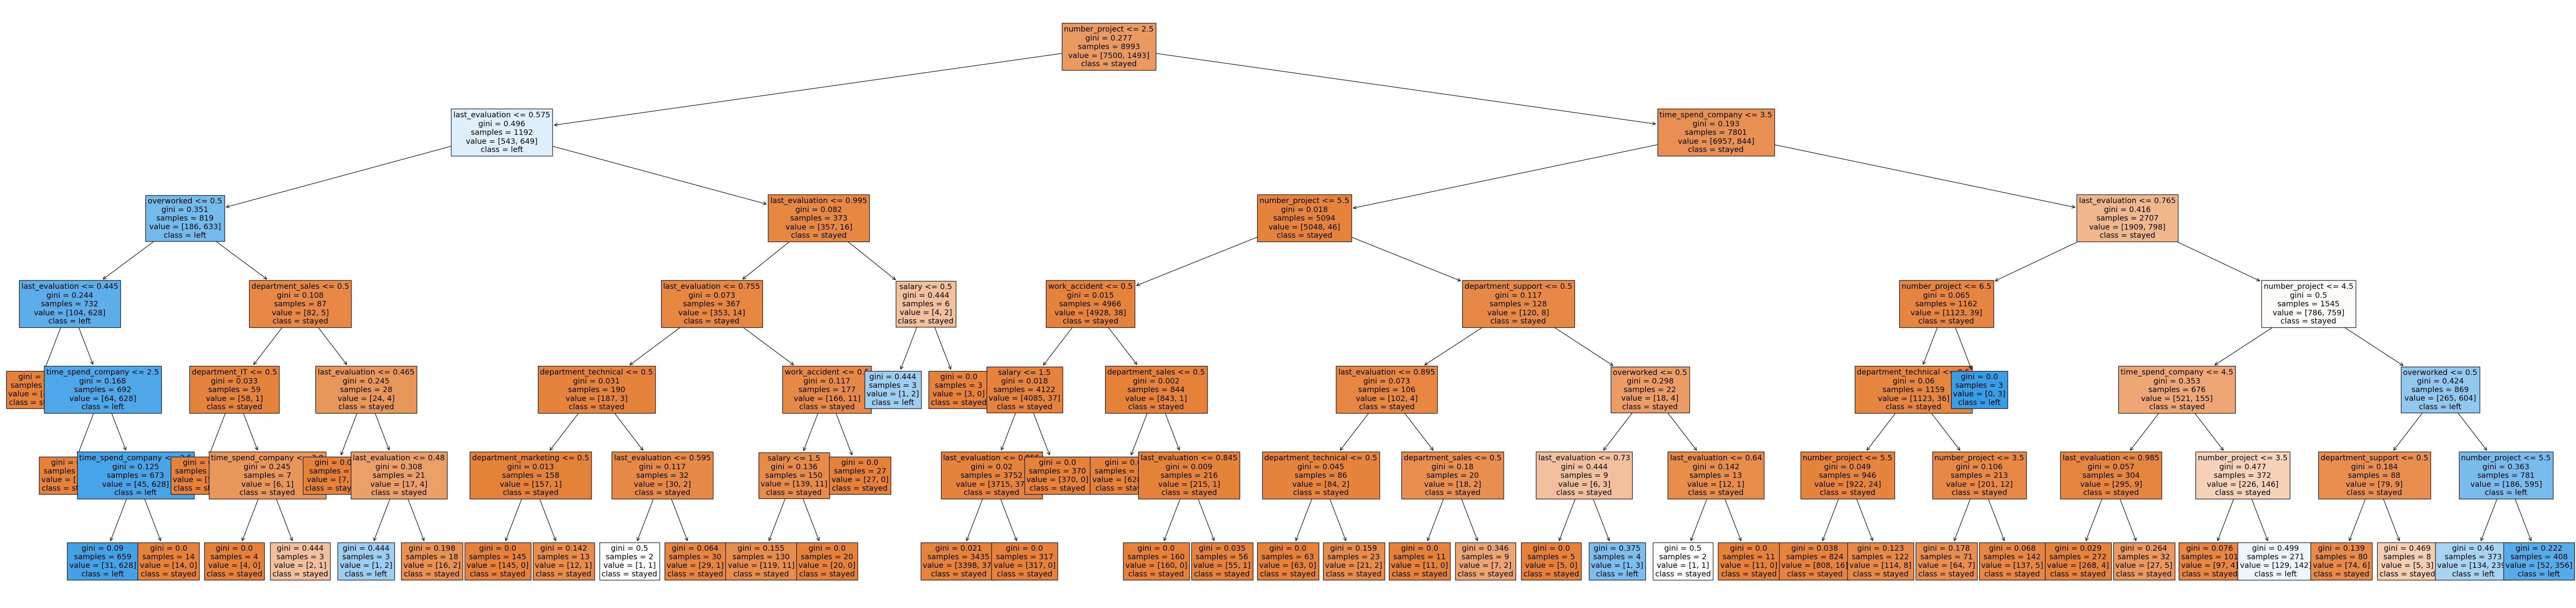

In [89]:
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_,max_depth=6,fontsize=14,feature_names=x.columns,class_names={0:'stayed',1:'left'},filled=True);
plt.show()

In [91]:
tree2_importances= pd.DataFrame(tree2.best_estimator_.feature_importances_,columns=['gini_importance'],index=x.columns)
tree2_importances= tree2_importances.sort_values(by='gini_importance',ascending=False)

tree2_importances = tree2_importances[tree2_importances['gini_importance'] !=0] # Only extract the features with importances > 0
tree2_importances

,gini_importance
last_evaluation,0.343958
number_project,0.343385
time_spend_company,0.215681
overworked,0.093498
department_support,0.001142
salary,0.000910
department_sales,0.000607
department_technical,0.000418
work_accident,0.000183
department_IT,0.000139


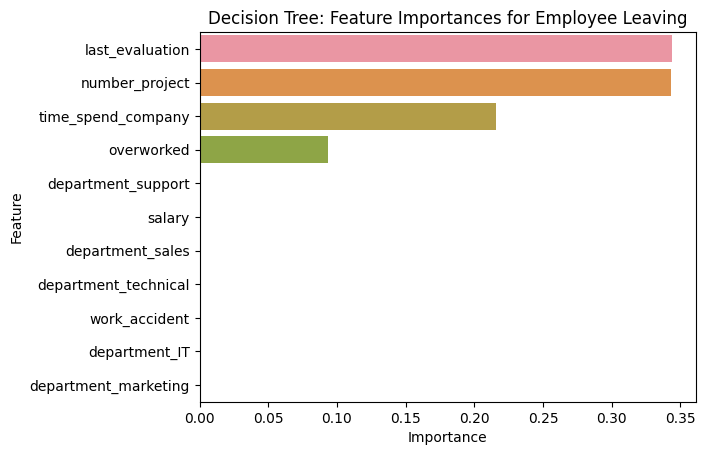

In [92]:
sns.barplot(data=tree2_importances,x='gini_importance',y=tree2_importances.index,orient='h')
plt.title('Decision Tree: Feature Importances for Employee Leaving',fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The barplot above shows that in this decision tree model, last_evaluation, number_project,
tenure, and overworked have the highest importance, in that order. These variables are most
helpful in predicting the outcome variable, left.

Random Forest Feature importance

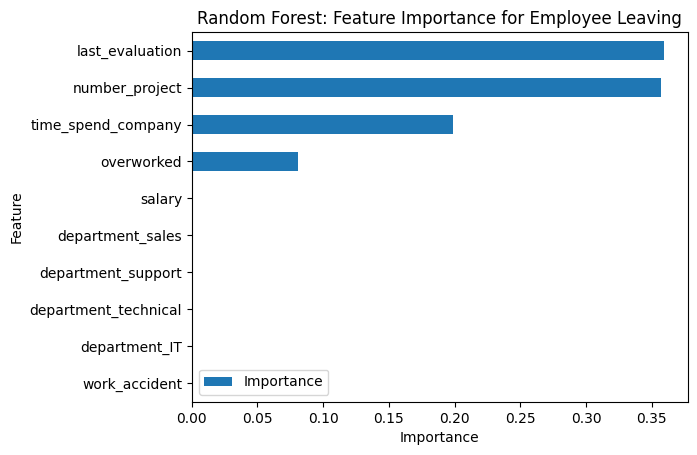

In [94]:
feat_impt = rf2.best_estimator_.feature_importances_
#Get indices of top 10 features
ind= np.argpartition(rf2.best_estimator_.feature_importances_,-10)[-10:]

feat=x.columns[ind]
feat_impt= feat_impt[ind]
y_df=pd.DataFrame({'Feature':feat,'Importance': feat_impt})
y_sort_df=y_df.sort_values('Importance')
fig=plt.figure()
ax1=fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x='Feature',y='Importance')

ax1.set_title('Random Forest: Feature Importance for Employee Leaving',fontsize=12)
ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')
plt.show()

The plot above shows that in this random forest model, last_evaluation, number_project,
tenure, and overworked have the highest importance, in that order. These variables are most
helpful in predicting the outcome variable, left, and they are the same as the ones used by the
decision tree model.


**Logistic Regression**

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted
averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.8%, precision
of 87.0%, recall of 90.4%, f1-score of 88.7%, and accuracy of 96.2%, on the test set. The random
forest modestly outperformed the decision tree model.

**Conclusion, Recommendations**

The models and the feature importances extracted from the models confirm that employees at the
company are overworked.

To retain employees, the following recommendations could be presented to the stakeholders
• Cap the number of projects that employees can work on.

• Consider promoting employees who have been with the company for atleast four years, or
conduct further investigation about why four-year tenured employees are so dissatisfied.

• Either reward employees for working longer hours, or don’t require them to do so.

• If employees aren’t familiar with the company’s overtime pay policies, inform them about
this. If the expectations around workload and time off aren’t explicit, make them clear.

• Hold company-wide and within-team discussions to understand and address the company
work culture, across the board and in specific contexts.

• High evaluation scores should not be reserved for employees who work 200+ hours per month.
Consider a proportionate scale for rewarding employees who contribute more/put in more
effort.